# A05: Control Flow, Warp Divergence, and Occupancy Analysis

**Student Name:** Kenneth Peter Fernandes

**Date:** 27 October 2025

## Overview
This notebook explores warp divergence in CUDA GPU programming using Numba. We will:
- Implement divergent and non-divergent kernels
- Measure performance differences
- Analyze the impact of thread block size on occupancy
- Answer conceptual questions about CUDA execution

# Numba CUDA Configuration

This cell configures Numba to use NVIDIA's JIT Link Time Optimization (LTO) backend. This optimization technique allows better performance by enabling device library linking at runtime and leveraging NVIDIA's `pynvjitlink` for improved CUDA code optimization.

In [1]:
from numba import config

# Enable Numba's support for NVIDIA's JIT LTO (Link Time Optimization) backend
# This allows Numba to use the NVIDIA JIT linker (pynvjitlink) to optimize CUDA code
# Helps improve performance and enables linking of device libraries at runtime
config.CUDA_ENABLE_PYNVJITLINK = 1

# Import Required Libraries

This cell imports all the necessary Python libraries for the notebook:
- **NumPy**: For numerical computations and array operations
- **Numba CUDA**: For writing GPU kernels in Python
- **Time**: For measuring kernel execution time
- **Matplotlib**: For creating performance visualization plots
- **Pandas**: For organizing experimental results in tabular format

In [2]:
import numpy as np              # For numerical operations and array handling
from numba import cuda          # To write and run GPU (CUDA) kernels in Python
import time                     # To measure execution time of code segments
import matplotlib.pyplot as plt  # For plotting graphs and visualizing results
import pandas as pd             # For organizing and analyzing data in tables (DataFrames)

# CUDA Availability Check

This cell verifies that a CUDA-capable GPU is available on the system. It checks:
- Whether CUDA is accessible
- The GPU device name
- The compute capability (which indicates the GPU architecture and supported features)

This is essential to ensure the notebook can run CUDA kernels properly.

In [3]:
# Check if a CUDA-capable GPU is available on this system
print("CUDA Available:", cuda.is_available())

if cuda.is_available():
    # If CUDA is available, print basic GPU device information

    # Display the name of the GPU currently being used
    print("CUDA Device:", cuda.get_current_device().name.decode())

    # Get the GPU's compute capability (major.minor version)
    major, minor = cuda.get_current_device().compute_capability

    # Print the compute capability, which indicates the GPU's architecture generation
    print(f"GPU Compute Capability: {major}.{minor} (Indicates supported CUDA features and architecture generation)")
else:
    # Warn the user if no CUDA-capable GPU is found
    print("WARNING: CUDA not available. This notebook requires a CUDA-capable GPU.")

CUDA Available: True
CUDA Device: Tesla T4
GPU Compute Capability: 7.5 (Indicates supported CUDA features and architecture generation)


# Detailed System and GPU Information

This cell provides comprehensive information about the runtime environment including:
- **Python version and platform details**
- **CUDA runtime version**
- **Detailed GPU specifications**: memory, compute capability, thread limits, multiprocessors
- **nvidia-smi output**: driver version, GPU utilization, and memory usage

This information is crucial for understanding the hardware constraints and capabilities that affect kernel performance.

In [4]:
# ================================================
# System + CUDA + GPU Runtime Info (Colab Friendly)
# This block prints environment, GPU, and memory info
# ================================================

from numba import cuda         # For accessing CUDA GPU info via Numba
import platform                # To get system-level info like OS and Python version
import numba                   # To check the Numba version in use

# ----------------------------------------
# Print Python and Platform Environment Info
# ----------------------------------------
print("=== Python Environment Info ===")
print(f"Python Version      : {platform.python_version()}")       # e.g., 3.10.12
print(f"Platform            : {platform.platform()}")             # OS info
print(f"Numba Version       : {numba.__version__}")               # Numba version

# ----------------------------------------
# Print CUDA Runtime + Device Info
# ----------------------------------------
print("\n=== CUDA + GPU Info ===")
print(f"CUDA Available      : {cuda.is_available()}")             # Check if CUDA is usable

try:
    # Try fetching CUDA runtime version (e.g., (11, 8))
    print(f"CUDA Runtime Version: {cuda.runtime.get_version()}")
except Exception as e:
    print(f"CUDA Runtime Version: Not available ({e})")

try:
    # Access current CUDA device and memory info
    device = cuda.get_current_device()
    free_mem, total_mem = cuda.current_context().get_memory_info()

    # Print detailed GPU specs and memory availability
    print(f"GPU Device Name     : {device.name}")                             # GPU name (e.g., Tesla T4)
    print(f"Compute Capability  : {device.compute_capability}")              # Architecture version (e.g., (7, 5))
    print(f"Total Memory (MB)   : {total_mem / 1024 ** 2:.2f} MB")           # Total VRAM in MB
    print(f"Free Memory (MB)    : {free_mem / 1024 ** 2:.2f} MB")            # Available VRAM in MB
    print(f"Max Threads/Block   : {device.MAX_THREADS_PER_BLOCK}")          # Upper limit of threads per block
    print(f"Max Block Dim       : {device.MAX_BLOCK_DIM_X}, "
          f"{device.MAX_BLOCK_DIM_Y}, {device.MAX_BLOCK_DIM_Z}")            # Max block dimensions in x, y, z
    print(f"Max Grid Dim        : {device.MAX_GRID_DIM_X}, "
          f"{device.MAX_GRID_DIM_Y}, {device.MAX_GRID_DIM_Z}")              # Max grid dimensions in x, y, z
    print(f"Multiprocessors     : {device.MULTIPROCESSOR_COUNT}")           # Number of SMs (cores)
    print(f"Warp Size           : {device.WARP_SIZE}")                       # Warp size (usually 32)
    print(f"Max Shared Mem/Block: {device.MAX_SHARED_MEMORY_PER_BLOCK / 1024:.2f} KB")  # Shared memory in KB
except cuda.cudadrv.error.CudaSupportError as e:
    print("CUDA Device Info: Not available (No compatible GPU?)")

# ----------------------------------------
# Print Output from nvidia-smi (for Colab or Linux)
# Shows driver version, memory, utilization, etc.
# ----------------------------------------
print("\n=== nvidia-smi (if available) ===")
!nvidia-smi || echo "nvidia-smi not available in this environment."

=== Python Environment Info ===
Python Version      : 3.12.12
Platform            : Linux-6.6.105+-x86_64-with-glibc2.35
Numba Version       : 0.60.0

=== CUDA + GPU Info ===
CUDA Available      : True
CUDA Runtime Version: (12, 6)
GPU Device Name     : b'Tesla T4'
Compute Capability  : (7, 5)
Total Memory (MB)   : 15095.06 MB
Free Memory (MB)    : 14992.12 MB
Max Threads/Block   : 1024
Max Block Dim       : 1024, 1024, 64
Max Grid Dim        : 2147483647, 65535, 65535
Multiprocessors     : 40
Warp Size           : 32
Max Shared Mem/Block: 48.00 KB

=== nvidia-smi (if available) ===
Tue Oct 28 02:56:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Tem

# CUDA Kernel: Threshold Function

This cell defines a simple CUDA kernel that demonstrates warp divergence. The kernel:
- Takes each element of an input array
- Compares it against a threshold value
- Sets the output to 1.0 if the value exceeds the threshold, otherwise 0.0

**Key Point**: The conditional `if-else` statement causes **warp divergence** when threads within the same warp take different execution paths. This happens when some threads execute the `if` branch while others execute the `else` branch, forcing the GPU to serialize execution and reducing performance.

In [5]:
@cuda.jit
def threshold_kernel(input_array, output_array, threshold):
    # Calculate the global thread index (unique ID for each thread)
    idx = cuda.grid(1)

    # Ensure the thread index is within the array size (bounds check)
    if idx < input_array.size:
        # If the input value is greater than the threshold, set output to 1
        if input_array[idx] > threshold:
            output_array[idx] = 1.0
        # Otherwise, set output to 0
        else:
            output_array[idx] = 0.0

# Helper Functions for Testing Warp Divergence

This cell defines utility functions for the warp divergence experiment:

**Input Data Generators:**
- `create_divergent_input()`: Creates linearly increasing values (0, 1, 2, ...) causing ~50% of threads to take each branch - **maximum divergence**
- `create_non_divergent_input_high()`: Creates uniformly high values where all threads take the same path (all above threshold) - **no divergence**
- `create_non_divergent_input_low()`: Creates uniformly low values where all threads take the same path (all below threshold) - **no divergence**

**Timing Function:**
- `run_kernel_with_timing()`: Launches the kernel multiple times, measures GPU execution time using CUDA events, and returns the average time

These functions enable controlled experiments to measure the performance impact of warp divergence.

In [6]:
# ---------------------------------------------------------------------------
# Creates input where values increase linearly: 0.0, 1.0, 2.0, ..., size-1
# This will cause some threads to go above the threshold and some below,
# leading to warp divergence.
# ---------------------------------------------------------------------------
def create_divergent_input(size):
    return np.arange(size, dtype=np.float32)

# ---------------------------------------------------------------------------
# Creates input where all values are high (well above any reasonable threshold)
# All threads will take the same execution path — no divergence.
# ---------------------------------------------------------------------------
def create_non_divergent_input_high(size):
    return np.full(size, size * 2.0, dtype=np.float32)

# ---------------------------------------------------------------------------
# Creates input where all values are low (well below any reasonable threshold)
# All threads will again follow the same path — no divergence.
# ---------------------------------------------------------------------------
def create_non_divergent_input_low(size):
    return np.full(size, -1.0, dtype=np.float32)

# ---------------------------------------------------------------------------
# Launch the threshold kernel on the GPU and measure average execution time.
# Optionally run it multiple times (default = 10) for stable timing results.
# ---------------------------------------------------------------------------
def run_kernel_with_timing(input_data, threshold, threads_per_block, num_runs=10):
    size = input_data.size

    # Prepare an output array filled with 0.0
    output_data = np.zeros(size, dtype=np.float32)

    # Copy input and output arrays to GPU device memory
    d_input = cuda.to_device(input_data)
    d_output = cuda.to_device(output_data)

    # Calculate how many blocks are needed to cover all elements
    blocks_per_grid = (size + threads_per_block - 1) // threads_per_block

    # Warm-up kernel launch (compiles the kernel and stabilizes runtime)
    threshold_kernel[blocks_per_grid, threads_per_block](d_input, d_output, threshold)
    cuda.synchronize()

    # List to store timing results
    times = []

    for _ in range(num_runs):
        # CUDA events give accurate GPU-side timing
        start = cuda.event()
        end = cuda.event()

        # Start timing
        start.record()

        # Launch kernel again with the same grid and block configuration
        threshold_kernel[blocks_per_grid, threads_per_block](d_input, d_output, threshold)

        # Stop timing
        end.record()
        end.synchronize()

        # Compute elapsed time in milliseconds
        elapsed_time = cuda.event_elapsed_time(start, end)
        times.append(elapsed_time)

    # Copy result back to host (optional, if result verification is needed)
    output_data = d_output.copy_to_host()

    # Return the average execution time and output result
    return np.mean(times), output_data

# Experiment Configuration

This cell sets up the parameters for the warp divergence experiments:

- **ARRAY_SIZE**: 1,048,576 elements (1M) - large enough to fully utilize the GPU
- **THRESHOLD**: Set to the middle value (524,288) to create 50/50 divergence
- **BLOCK_SIZE**: 256 threads per block (8 warps of 32 threads each)
- **NUM_TIMING_RUNS**: 20 iterations for averaging to get stable timing measurements

These parameters control the scale of the experiment and ensure reproducible results.

In [7]:
# ----------------------------------------------
# Set the size of the input array (1 million elements)
# ----------------------------------------------
ARRAY_SIZE = 1024 * 1024  # 1,048,576 elements

# ----------------------------------------------
# Threshold value used in the kernel (middle value)
# Half the input will be below, half above (for divergence)
# ----------------------------------------------
THRESHOLD = ARRAY_SIZE / 2

# ----------------------------------------------
# Number of threads per block (CUDA block size)
# Must be a multiple of 32 (warp size)
# ----------------------------------------------
BLOCK_SIZE = 256

# ----------------------------------------------
# Number of times to run the kernel for averaging execution time
# Helps get a more stable measurement
# ----------------------------------------------
NUM_TIMING_RUNS = 20

# ----------------------------------------------
# Print configuration info for reference
# ----------------------------------------------
print(f"Array Size: {ARRAY_SIZE:,}")                # e.g., 1,048,576
print(f"Threshold: {THRESHOLD}")                    # 524,288.0
print(f"Block Size: {BLOCK_SIZE}")                  # 256
print(f"Warps per block: {BLOCK_SIZE // 32}")       # 8 warps of 32 threads each
print(f"Number of timing runs: {NUM_TIMING_RUNS}\n")

Array Size: 1,048,576
Threshold: 524288.0
Block Size: 256
Warps per block: 8
Number of timing runs: 20



# Test 1: Divergent Execution (Maximum Warp Divergence)

This cell runs the **worst-case scenario** for warp divergence:

**Setup**: Input data has linearly increasing values, so approximately 50% of threads will be above the threshold and 50% below.

**Expected Behavior**: Within each warp, threads will split between the `if` and `else` branches, causing the GPU to execute both paths sequentially. This serialization of execution reduces parallelism and can impact performance.

**Output Verification**: Confirms that roughly half the values are set to 1.0 and half to 0.0, validating the divergent behavior.

In [8]:
# ===============================================================
# Run Version A: Divergent kernel (half threads take 'true', half 'false')
# This setup causes warp divergence due to conditional branching
# ===============================================================
print("=" * 60)
print("VERSION A: DIVERGENT EXECUTION (50% true, 50% false)")
print("=" * 60)

# Generate input data that increases linearly: 0.0, 1.0, 2.0, ..., size-1
# About half the values will be below the threshold, half above
input_divergent = create_divergent_input(ARRAY_SIZE)

# Launch the kernel and measure average execution time
time_divergent, output_divergent = run_kernel_with_timing(
    input_divergent, THRESHOLD, BLOCK_SIZE, NUM_TIMING_RUNS
)

# ----------------------------------------------
# Verify the output: Count how many elements were set to 1.0 or 0.0
# ----------------------------------------------
num_ones = np.sum(output_divergent == 1.0)
num_zeros = np.sum(output_divergent == 0.0)

# Print verification results
print(f"Output verification:")
print(f"  - Values set to 1.0: {num_ones:,} ({100*num_ones/ARRAY_SIZE:.1f}%)")
print(f"  - Values set to 0.0: {num_zeros:,} ({100*num_zeros/ARRAY_SIZE:.1f}%)")
print(f"  - Expected: ~50% ones, ~50% zeros")

# ----------------------------------------------
# Print kernel execution time (averaged over runs)
# ----------------------------------------------
print(f"\nExecution time: {time_divergent:.4f} ms")

VERSION A: DIVERGENT EXECUTION (50% true, 50% false)
Output verification:
  - Values set to 1.0: 524,287 (50.0%)
  - Values set to 0.0: 524,289 (50.0%)
  - Expected: ~50% ones, ~50% zeros

Execution time: 0.1086 ms


# Test 2: Non-Divergent Execution (All Threads Take True Branch)

This cell runs a **best-case scenario** with no warp divergence:

**Setup**: All input values are set well above the threshold, ensuring all threads take the same execution path (the `if` branch).

**Expected Behavior**: All threads within each warp execute in lockstep - no divergence occurs. The GPU can execute all threads in parallel without serialization.

**Output Verification**: Confirms that 100% of values are set to 1.0, validating that all threads took the true branch.

In [9]:
# ===============================================================
# Run Version B: Non-Divergent kernel (all threads take 'true' path)
# Input is designed so every element is above the threshold
# → No warp divergence occurs
# ===============================================================
print("=" * 60)
print("VERSION B: NON-DIVERGENT EXECUTION (100% true)")
print("=" * 60)

# Generate input where all values are much greater than the threshold
# This ensures all threads take the same branch (if → true)
input_non_divergent_high = create_non_divergent_input_high(ARRAY_SIZE)

# Launch the kernel and measure average execution time
time_non_divergent_high, output_non_divergent_high = run_kernel_with_timing(
    input_non_divergent_high, THRESHOLD, BLOCK_SIZE, NUM_TIMING_RUNS
)

# ----------------------------------------------
# Verify the output: All elements should be set to 1.0
# ----------------------------------------------
num_ones = np.sum(output_non_divergent_high == 1.0)

# Print verification results
print(f"Output verification:")
print(f"  - Values set to 1.0: {num_ones:,} ({100*num_ones/ARRAY_SIZE:.1f}%)")
print(f"  - Expected: 100% ones (all values above threshold)")

# ----------------------------------------------
# Print kernel execution time (averaged over runs)
# ----------------------------------------------
print(f"\nExecution time: {time_non_divergent_high:.4f} ms")

VERSION B: NON-DIVERGENT EXECUTION (100% true)
Output verification:
  - Values set to 1.0: 1,048,576 (100.0%)
  - Expected: 100% ones (all values above threshold)

Execution time: 0.1343 ms


# Test 3: Non-Divergent Execution (All Threads Take False Branch)

This cell runs another **best-case scenario** with no warp divergence:

**Setup**: All input values are set well below the threshold, ensuring all threads take the same execution path (the `else` branch).

**Expected Behavior**: All threads within each warp execute the same instruction path in lockstep - no divergence occurs. Similar to Test 2, but all threads take the false branch instead.

**Output Verification**: Confirms that 100% of values are set to 0.0, validating that all threads took the false branch.

This test, combined with Test 2, helps isolate whether any performance difference is due to warp divergence versus which branch is taken.

In [10]:
# ===============================================================
# Run Version B (ALT): Non-Divergent kernel (all threads take 'false' path)
# Input is designed so every value is below the threshold
# → No warp divergence occurs
# ===============================================================
print("=" * 60)
print("VERSION B (ALT): NON-DIVERGENT EXECUTION (100% false)")
print("=" * 60)

# Generate input where all values are much lower than the threshold
# This ensures all threads take the same branch (else → false)
input_non_divergent_low = create_non_divergent_input_low(ARRAY_SIZE)

# Launch the kernel and measure average execution time
time_non_divergent_low, output_non_divergent_low = run_kernel_with_timing(
    input_non_divergent_low, THRESHOLD, BLOCK_SIZE, NUM_TIMING_RUNS
)

# ----------------------------------------------
# Verify the output: All elements should be set to 0.0
# ----------------------------------------------
num_zeros = np.sum(output_non_divergent_low == 0.0)

# Print verification results
print(f"Output verification:")
print(f"  - Values set to 0.0: {num_zeros:,} ({100*num_zeros/ARRAY_SIZE:.1f}%)")
print(f"  - Expected: 100% zeros (all values below threshold)")

# ----------------------------------------------
# Print kernel execution time (averaged over runs)
# ----------------------------------------------
print(f"\nExecution time: {time_non_divergent_low:.4f} ms")

VERSION B (ALT): NON-DIVERGENT EXECUTION (100% false)
Output verification:
  - Values set to 0.0: 1,048,576 (100.0%)
  - Expected: 100% zeros (all values below threshold)

Execution time: 0.1229 ms


# Performance Comparison Summary

This cell analyzes and compares the execution times from all three test cases:

**Analysis Steps**:
1. Creates a summary DataFrame with all execution times and branch distributions
2. Calculates the average execution time of the two non-divergent cases (baseline)
3. Computes the **performance penalty** as a percentage difference between divergent and non-divergent execution

**Key Metric**: The performance penalty reveals how much warp divergence impacts kernel performance. 
- A positive penalty indicates the divergent case is slower (expected in most architectures)
- A negative penalty might occur due to measurement noise or specific GPU optimizations

In [11]:
# ------------------------------------------------------------
# Create a DataFrame summarizing the execution times of all kernel versions
# ------------------------------------------------------------
results_df = pd.DataFrame({
    'Version': ['Divergent (50/50)', 'Non-Divergent (All True)', 'Non-Divergent (All False)'],
    'Execution Time (ms)': [time_divergent, time_non_divergent_high, time_non_divergent_low],
    'Branch Distribution': ['50% true, 50% false', '100% true', '100% false']
})

# ------------------------------------------------------------
# Calculate the average time of the two non-divergent versions
# This will be used as a baseline for comparison
# ------------------------------------------------------------
avg_non_divergent = (time_non_divergent_high + time_non_divergent_low) / 2

# ------------------------------------------------------------
# Calculate the performance penalty (as percentage)
# Shows how much slower the divergent version is compared to the non-divergent average
# ------------------------------------------------------------
penalty_percent = ((time_divergent - avg_non_divergent) / avg_non_divergent) * 100

# ------------------------------------------------------------
# Print the results and key performance metrics
# ------------------------------------------------------------
print("\n" + "=" * 60)
print("PERFORMANCE COMPARISON")
print("=" * 60)
print(results_df.to_string(index=False))  # Nicely format the DataFrame as a table

print("\n" + "-" * 60)
print("KEY METRICS:")
print("-" * 60)
print(f"Average non-divergent time: {avg_non_divergent:.4f} ms")
print(f"Divergent time:             {time_divergent:.4f} ms")
print(f"Performance penalty:        {penalty_percent:+.2f}%")
print("=" * 60)


PERFORMANCE COMPARISON
                  Version  Execution Time (ms) Branch Distribution
        Divergent (50/50)             0.108589 50% true, 50% false
 Non-Divergent (All True)             0.134301           100% true
Non-Divergent (All False)             0.122853          100% false

------------------------------------------------------------
KEY METRICS:
------------------------------------------------------------
Average non-divergent time: 0.1286 ms
Divergent time:             0.1086 ms
Performance penalty:        -15.55%


# Block Size Sweep Experiment

This cell investigates how **thread block size** affects kernel performance and warp divergence impact:

**Experiment Design**:
- Tests multiple block sizes: 32, 64, 128, 256, 512, 1024 threads per block
- For each block size, runs both divergent and non-divergent kernels
- Collects timing data and calculates divergence penalty

**Why Block Size Matters**:
- **Occupancy**: Larger blocks may improve GPU occupancy (more warps active per SM)
- **Scheduling**: Different block sizes affect how the GPU schedules warps
- **Resource utilization**: Block size impacts shared memory and register usage

**Key Insights to Look For**:
- Which block size achieves the best performance?
- Does the optimal block size differ between divergent and non-divergent cases?
- How does divergence penalty vary with block size?

In [12]:
# ------------------------------------------------------------------------
# Test how different CUDA block sizes impact kernel performance and occupancy
# ------------------------------------------------------------------------
BLOCK_SIZES = [32, 64, 128, 256, 512, 1024]  # Common block sizes (multiples of warp size)

# Dictionary to collect timing results and occupancy metrics
block_size_results = {
    'block_size': [],
    'divergent_time': [],
    'non_divergent_time': [],
    'blocks_per_grid': []
}

# ------------------------------------------------------------
# Begin block size sweep experiment
# ------------------------------------------------------------
print("\n" + "=" * 70)
print("BLOCK SIZE SWEEP EXPERIMENT")
print("=" * 70)
print("Testing how thread block size affects performance and occupancy...")
print()

# Loop through each block size to test its performance
for block_size in BLOCK_SIZES:
    print(f"\nTesting block size: {block_size}")
    print("-" * 50)

    # --------------------------------------------------------
    # Test 1: Divergent case (50/50 branch) → worst performance scenario
    # --------------------------------------------------------
    input_div = create_divergent_input(ARRAY_SIZE)
    time_div, _ = run_kernel_with_timing(input_div, THRESHOLD, block_size, NUM_TIMING_RUNS)

    # --------------------------------------------------------
    # Test 2: Non-divergent case (100% true) → best performance scenario
    # --------------------------------------------------------
    input_non_div = create_non_divergent_input_high(ARRAY_SIZE)
    time_non_div, _ = run_kernel_with_timing(input_non_div, THRESHOLD, block_size, NUM_TIMING_RUNS)

    # --------------------------------------------------------
    # Calculate grid configuration: how many blocks are needed
    # to cover the full array with the current block size
    # --------------------------------------------------------
    blocks_per_grid = (ARRAY_SIZE + block_size - 1) // block_size

    # --------------------------------------------------------
    # Save results to the dictionary for final summary
    # --------------------------------------------------------
    block_size_results['block_size'].append(block_size)
    block_size_results['divergent_time'].append(time_div)
    block_size_results['non_divergent_time'].append(time_non_div)
    block_size_results['blocks_per_grid'].append(blocks_per_grid)

    # --------------------------------------------------------
    # Print performance metrics for this configuration
    # --------------------------------------------------------
    warps_per_block = block_size // 32  # Each warp = 32 threads
    print(f"  Warps per block:    {warps_per_block}")
    print(f"  Blocks per grid:    {blocks_per_grid}")
    print(f"  Divergent time:     {time_div:.4f} ms")
    print(f"  Non-divergent time: {time_non_div:.4f} ms")
    print(f"  Divergence penalty: {((time_div - time_non_div) / time_non_div * 100):+.2f}%")

# ============================================================================
# Create a DataFrame from the collected block size sweep results
# This makes it easier to visualize and plot later
# ============================================================================
occupancy_df = pd.DataFrame(block_size_results)

# Print summary table to console
print("\n" + "=" * 70)
print("SUMMARY TABLE: Block Size Performance")
print("=" * 70)
print(occupancy_df.to_string(index=False))


BLOCK SIZE SWEEP EXPERIMENT
Testing how thread block size affects performance and occupancy...


Testing block size: 32
--------------------------------------------------
  Warps per block:    1
  Blocks per grid:    32768
  Divergent time:     0.1445 ms
  Non-divergent time: 0.1410 ms
  Divergence penalty: +2.48%

Testing block size: 64
--------------------------------------------------
  Warps per block:    2
  Blocks per grid:    16384
  Divergent time:     0.1052 ms
  Non-divergent time: 0.1079 ms
  Divergence penalty: -2.53%

Testing block size: 128
--------------------------------------------------
  Warps per block:    4
  Blocks per grid:    8192
  Divergent time:     0.0963 ms
  Non-divergent time: 0.0972 ms
  Divergence penalty: -0.94%

Testing block size: 256
--------------------------------------------------
  Warps per block:    8
  Blocks per grid:    4096
  Divergent time:     0.0972 ms
  Non-divergent time: 0.0976 ms
  Divergence penalty: -0.41%

Testing block size: 51

# Performance Visualization Plots

This cell creates two important visualizations to analyze the block size sweep results:

**Plot 1: Block Size vs Execution Time (Line Plot)**
- Compares execution time across different block sizes
- Shows separate lines for divergent and non-divergent cases
- Highlights the optimal block size (minimum execution time for divergent case)
- Helps identify which block size provides the best performance

**Plot 2: Warp Divergence Performance Penalty (Bar Chart)**
- Shows the percentage performance penalty due to warp divergence for each block size
- Positive values indicate divergent code is slower
- Negative values may indicate measurement noise or GPU-specific optimizations
- Reveals how the impact of warp divergence varies with block size

These visualizations make it easy to identify trends and optimal configurations for GPU kernel execution.

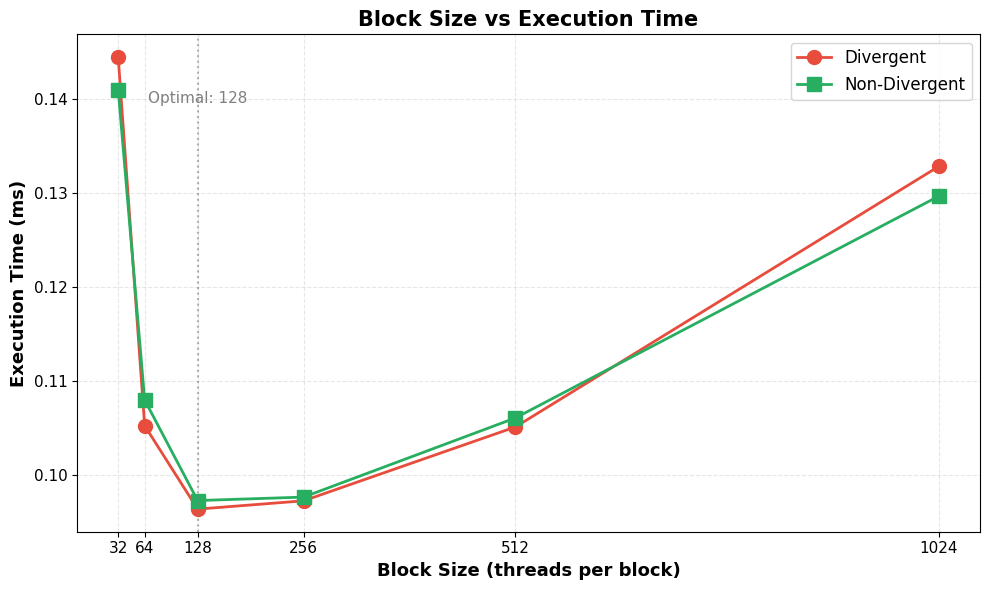

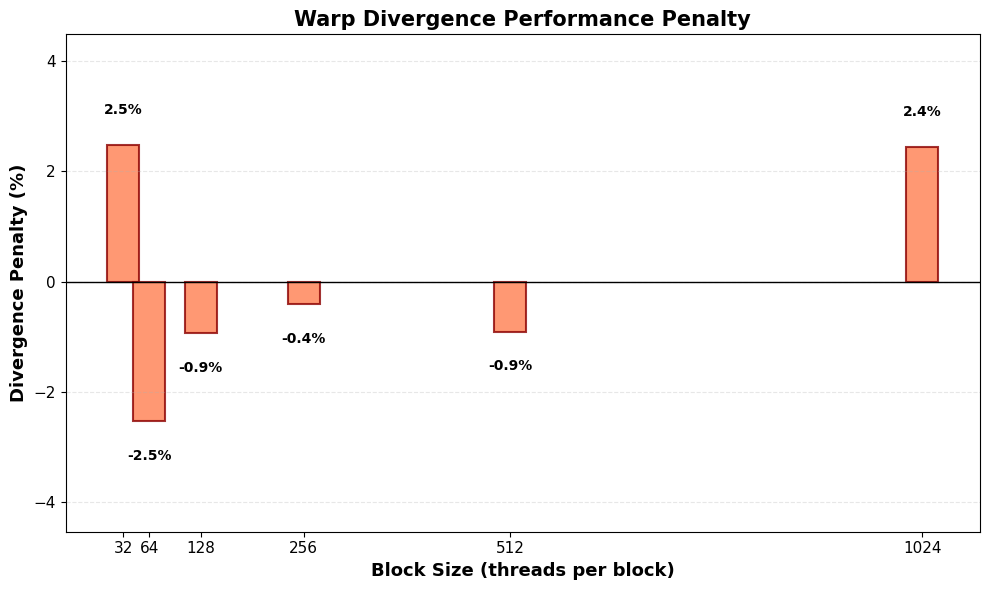

In [13]:
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Ensure BLOCK_SIZES are available for plotting
# ------------------------------------------------------------
if 'BLOCK_SIZES' not in globals():
    BLOCK_SIZES = list(occupancy_df['block_size'])

# ------------------------------------------------------------
# Calculate divergence penalty as percentage for each block size
# ------------------------------------------------------------
penalty = [
    ((d - n) / n) * 100 if n != 0 else 0
    for d, n in zip(occupancy_df['divergent_time'], occupancy_df['non_divergent_time'])
]

# ============================================================================
# PLOT 1: Block Size vs Execution Time (Line Plot)
# ============================================================================
plt.figure(figsize=(10, 6))

# Plot divergent kernel timing
plt.plot(occupancy_df['block_size'], occupancy_df['divergent_time'],
         marker='o', linewidth=2, markersize=10, label='Divergent', color='#e74c3c')

# Plot non-divergent kernel timing
plt.plot(occupancy_df['block_size'], occupancy_df['non_divergent_time'],
         marker='s', linewidth=2, markersize=10, label='Non-Divergent', color='#27ae60')

# Axis configuration
plt.xlabel('Block Size (threads per block)', fontsize=13, fontweight='bold')
plt.ylabel('Execution Time (ms)', fontsize=13, fontweight='bold')
plt.title('Block Size vs Execution Time', fontsize=15, fontweight='bold')
plt.xticks(BLOCK_SIZES, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=12)

# Annotate the block size with the fastest divergent execution time
min_idx = occupancy_df['divergent_time'].idxmin()
optimal_block_size = occupancy_df.loc[min_idx, 'block_size']
plt.axvline(x=optimal_block_size, color='gray', linestyle=':', alpha=0.6)
plt.text(optimal_block_size, plt.ylim()[1]*0.95,
         f'Optimal: {optimal_block_size}',
         ha='center', fontsize=11, color='gray')

plt.tight_layout()
plt.show()

print("\n")

# ============================================================================
# PLOT 2: Warp Divergence Performance Penalty (Bar Plot)
# ============================================================================
plt.figure(figsize=(10, 6))

# Create the bar chart
bars = plt.bar(occupancy_df['block_size'], penalty,
               color='coral', alpha=0.8,
               width=40, edgecolor='darkred', linewidth=1.5)

# Configure axes and title
plt.xlabel('Block Size (threads per block)', fontsize=13, fontweight='bold')
plt.ylabel('Divergence Penalty (%)', fontsize=13, fontweight='bold')
plt.title('Warp Divergence Performance Penalty', fontsize=15, fontweight='bold')
plt.xticks(BLOCK_SIZES, fontsize=11)
plt.yticks(fontsize=11)
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.grid(True, axis='y', alpha=0.3, linestyle='--')

# Dynamically set y-axis limits with padding to avoid cutoff
y_min = min(penalty) - 2
y_max = max(penalty) + 2
plt.ylim(y_min, y_max)

# Annotate each bar with its percentage value, positioned safely within the plot
for bar, p in zip(bars, penalty):
    height = bar.get_height()
    x_center = bar.get_x() + bar.get_width() / 2
    label = f'{p:.1f}%'

    if height < 0:
        # Label below bar but above y_min
        y_position = max(height - 0.5, y_min + 0.5)
        va = 'top'
    else:
        # Label above bar but below y_max
        y_position = min(height + 0.5, y_max - 0.5)
        va = 'bottom'

    plt.text(x_center, y_position, label,
             ha='center', va=va, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# GPU Occupancy and Resource Analysis

This cell provides a detailed analysis of GPU occupancy and resource utilization:

**GPU Hardware Properties**:
- Device name and compute capability
- Maximum threads per block and warp size
- Number of streaming multiprocessors (SMs)
- Maximum block dimensions

**Occupancy Analysis**:
For each tested block size, calculates:
- **Warps per block**: How many warps (groups of 32 threads) fit in each block
- **Total blocks**: Number of thread blocks needed to cover the entire array
- **Total warps**: Total number of warps across the entire grid

**Understanding Occupancy**:
- Higher occupancy (more active warps per SM) generally improves latency hiding
- However, optimal performance doesn't always come from maximum occupancy
- Trade-offs exist between occupancy and per-thread resource availability

This information helps understand why certain block sizes perform better than others.

In [ ]:
# ============================================================================
# OCCUPANCY ESTIMATION AND DEVICE ANALYSIS
# ============================================================================
# Occupancy is the ratio of active warps to maximum possible warps per SM
# Higher occupancy → better latency hiding → better performance (usually)

if cuda.is_available():
    device = cuda.get_current_device()

    print("\n" + "=" * 70)
    print("GPU DEVICE PROPERTIES")
    print("=" * 70)

    # Display key hardware specifications
    print(f"\nDevice Name:        {device.name.decode()}")
    print(f"Compute Capability: {device.compute_capability}")

    # These properties determine occupancy limits
    print(f"\nHARDWARE LIMITS:")
    print(f"  Max threads per block:  {device.MAX_THREADS_PER_BLOCK}")
    print(f"  Warp size:              {device.WARP_SIZE} threads")
    print(f"  Number of SMs:          {device.MULTIPROCESSOR_COUNT}")

    # Max warps per SM varies by compute capability
    # Example:
    # - Compute 7.5 (Turing): 32 warps/SM
    # - Compute 8.6 (Ampere): 48 warps/SM
    print(f"  Max block dimensions:   ({device.MAX_BLOCK_DIM_X}, "
          f"{device.MAX_BLOCK_DIM_Y}, {device.MAX_BLOCK_DIM_Z})")

    # ========================================================================
    # Calculate Theoretical Occupancy Metrics
    # ========================================================================
    print("\n" + "-" * 70)
    print("OCCUPANCY ANALYSIS BY BLOCK SIZE")
    print("-" * 70)
    print(f"{'Block Size':<15} {'Warps/Block':<15} {'Total Blocks':<15} "
          f"{'Total Warps':<15}")
    print("-" * 70)

    for block_size in BLOCK_SIZES:
        # Number of warps in each block (always round up)
        warps_per_block = (block_size + device.WARP_SIZE - 1) // device.WARP_SIZE

        # Total blocks needed to cover the array
        total_blocks = (ARRAY_SIZE + block_size - 1) // block_size

        # Total warps across entire grid
        total_warps = warps_per_block * total_blocks

        print(f"{block_size:<15} {warps_per_block:<15} {total_blocks:<15} {total_warps:<15}")

    print("=" * 70)

else:
    print("\n CUDA not available - cannot query device properties")
    print("Run this notebook on a system with a CUDA-capable GPU")


GPU DEVICE PROPERTIES

Device Name:        Tesla T4
Compute Capability: (7, 5)

HARDWARE LIMITS:
  Max threads per block:  1024
  Warp size:              32 threads
  Number of SMs:          40
  Max block dimensions:   (1024, 1024, 64)

----------------------------------------------------------------------
OCCUPANCY ANALYSIS BY BLOCK SIZE
----------------------------------------------------------------------
Block Size      Warps/Block     Total Blocks    Total Warps    
----------------------------------------------------------------------
32              1               32768           32768          
64              2               16384           32768          
128             4               8192            32768          
256             8               4096            32768          
512             16              2048            32768          
1024            32              1024            32768          
